<a href="https://colab.research.google.com/github/elariekerboull/master_uppsala/blob/main/Exercise_10_real_time_noise_rejection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This function is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model.

In [2]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import tensorflow as tf
######################################Calculate FLOPS##########################################
def get_flops(model):
    '''
    Calculate FLOPS
    Parameters
    ----------
    model : tf.keras.Model
        Model for calculating FLOPS.

    Returns
    -------
    flops.total_float_ops : int
        Calculated FLOPS for the model
    '''

    batch_size = 1
    #input_shape = [batch_size] + model.inputs[0].shape[1:]

    #real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + list(model.inputs[0].shape[1:]), model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

Downloading the data (1 signal data file and 5 noise data files)

In [3]:
# download data file that contains signal events
if not os.path.exists("trimmed100_data_signal_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


Downloading...
From: https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq
To: /content/trimmed100_data_signal_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 108MB/s]


In [4]:
# download data file that contains noise events
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0001.npy"):
  !gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0002.npy"):
  !gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0003.npy"):
  !gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0004.npy"):
  !gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0005.npy"):
  !gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 97.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx
To: /con

Load the data into memory and combine it into one array.

In [5]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [6]:
# combine noise and signal data set
x = np.vstack((noise, signal))
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal.
y = np.ones(len(x))
y[:len(noise)] = 0

(599997, 100)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below.

In [7]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=int)
np.random.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]

# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


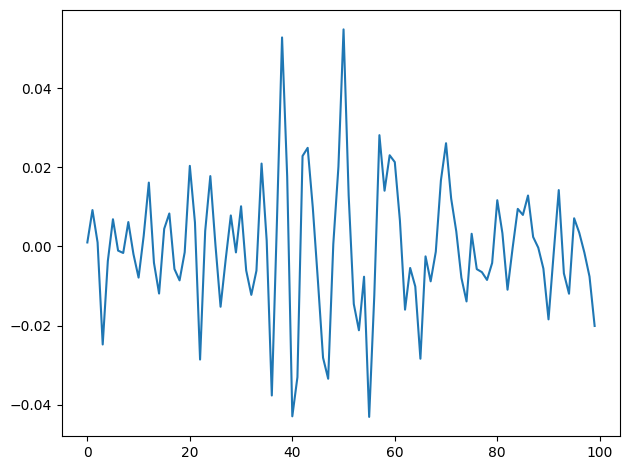

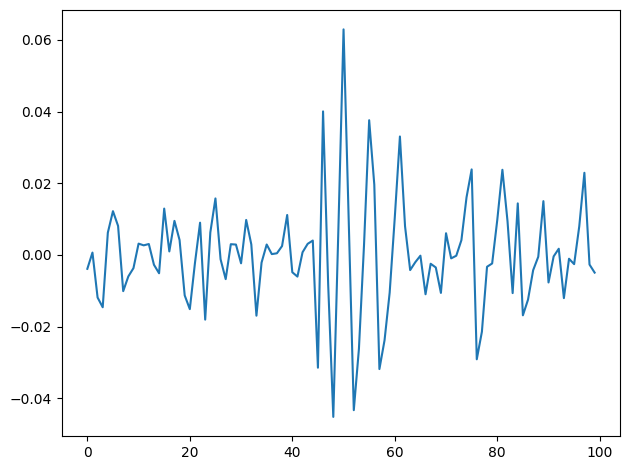

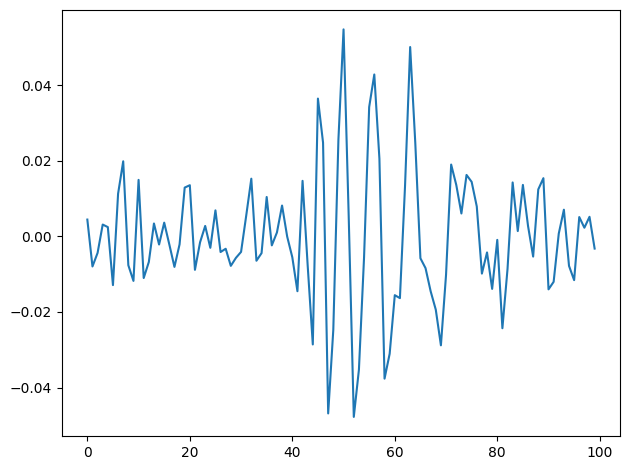

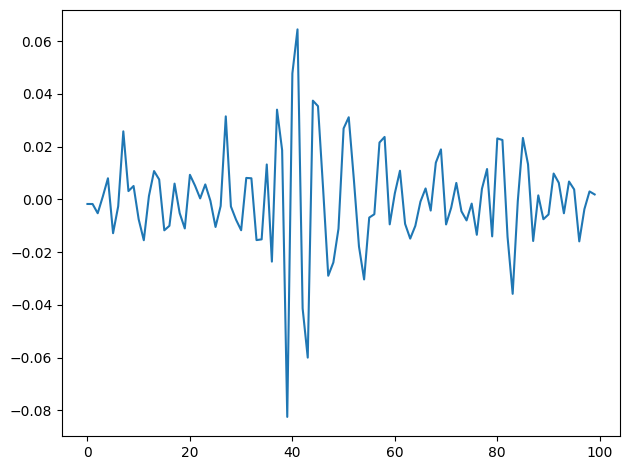

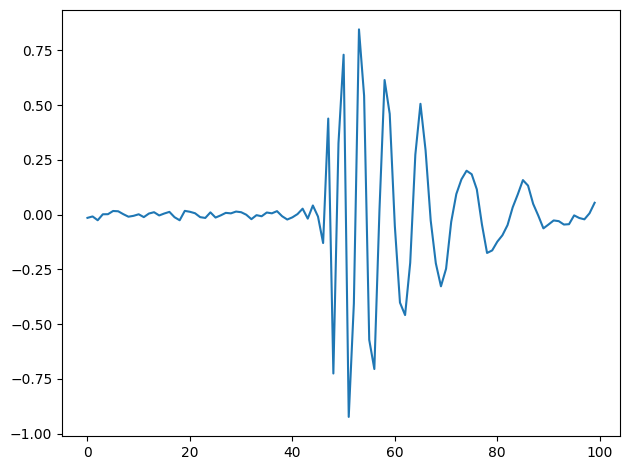

In [8]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

*Plotting several signals displays their variety in terms of amplitude as well as in form - each signal seems to display a unique character.*

In [9]:
n_test = 200000

data_test = x[-n_test:-1]
labels_test = y[-n_test:-1]

data_train = x[:-n_test]
labels_train = y[:-n_test]

print(f"{len(labels_train)} event in training/validation data set")
print(data_train.shape)
print(labels_train.shape)
sample_size = len(data_train[0])

399997 event in training/validation data set
(399997, 100)
(399997,)


In [10]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(sample_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])
model.summary()

checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', "model_best.keras"),
                                                   monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True, mode='auto',
                             save_weights_only=False)
#csv_logger = keras.callbacks.CSVLogger(os.path.join('saved_models', "model_history_log.csv"), append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 16)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
Total params: 849 (3.32 KB)
Trainable params: 849 (3.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history = model.fit(x=data_train, y=labels_train, batch_size=32, validation_split=0.2, epochs=200,
          callbacks=[checkpoint, early_stopping])

Epoch 1/200
 9995/10000 [============================>.] - ETA: 0s - loss: 0.3883 - accuracy: 0.8484
Epoch 1: val_accuracy improved from -inf to 0.88211, saving model to saved_models/model_best.keras
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3883 - accuracy: 0.8484 - val_loss: 0.2868 - val_accuracy: 0.8821
Epoch 2/200
 9991/10000 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9135
Epoch 2: val_accuracy improved from 0.88211 to 0.94117, saving model to saved_models/model_best.keras
10000/10000 [==============================] - 28s 3ms/step - loss: 0.2158 - accuracy: 0.9136 - val_loss: 0.1588 - val_accuracy: 0.9412
Epoch 3/200
 9988/10000 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9563
Epoch 3: val_accuracy improved from 0.94117 to 0.96973, saving model to saved_models/model_best.keras
10000/10000 [==============================] - 28s 3ms/step - loss: 0.1226 - accuracy: 0.9563 - val_loss: 0.0980 - val_acc

6250/6250 [==============================] - 9s 1ms/step


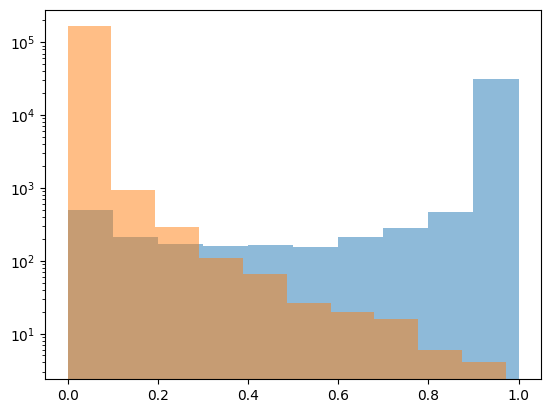

6250/6250 [==============================] - 9s 1ms/step
noise identified as noise 0.9996
signals identified as signals 0.9640


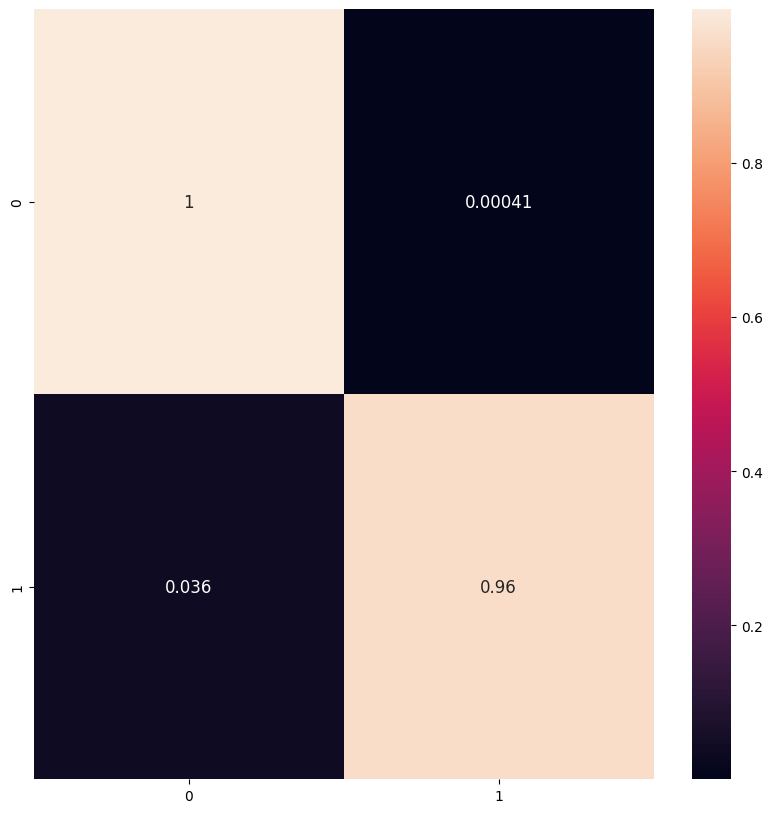

In [12]:
model.evaluate(data_test, labels_test)

y_pred = model.predict(data_test)
smask = labels_test == 1
plt.hist(y_pred[smask], log=True, alpha=0.5)
plt.hist(y_pred[~smask], log=True, alpha=0.5)
plt.show()
#
ypred = model.predict(data_test)[:,0]
ypred_binary = np.zeros(len(ypred), dtype=int)
ypred_binary[ypred > 0.5] = 1

n_mask = labels_test == 0
true_n_rate = np.sum(ypred_binary[n_mask] == 0) / np.sum(n_mask)
print(f"noise identified as noise {true_n_rate:.4f}")
g_mask = labels_test == 1
true_g_rate = np.sum(ypred_binary[g_mask] == 1) / np.sum(g_mask)
print(f"signals identified as signals {true_g_rate:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(labels_test, ypred_binary, normalize='true')
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()


In [13]:
get_flops(model)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


14113

In [11]:
model2 = Sequential()
model2.add(keras.layers.SeparableConv1D(filters=8, kernel_size=3, activation='relu', input_shape=(sample_size, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ separable_conv1d (SeparableConv1D)   │ (None, 98, 8)               │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 392)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             393 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 412 (1.61 KB)

 Trainable params: 412 (1.61 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model2.fit(x=data_train, y=labels_train, batch_size=32, validation_split=0.2, epochs=200,
          callbacks=[checkpoint, early_stopping])

Epoch 1/200
 9993/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8343 - loss: 0.4689
Epoch 1: val_accuracy improved from -inf to 0.86493, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.8343 - loss: 0.4689 - val_accuracy: 0.8649 - val_loss: 0.3306
Epoch 2/200
 9997/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8913 - loss: 0.2720
Epoch 2: val_accuracy improved from 0.86493 to 0.94568, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - accuracy: 0.8913 - loss: 0.2720 - val_accuracy: 0.9457 - val_loss: 0.1529
Epoch 3/200
 9998/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9541 - loss: 0.1326
Epoch 3: val_accuracy improved from 0.94568 to 0.96841, saving model to saved_models/model_best.keras
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9541 - loss: 0.1326 - val_accuracy: 0.9684 - val_loss: 0.0948
Epoch 4/200
 9992/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

In [13]:
get_flops(model2)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


4509

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9922 - loss: 0.0284
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


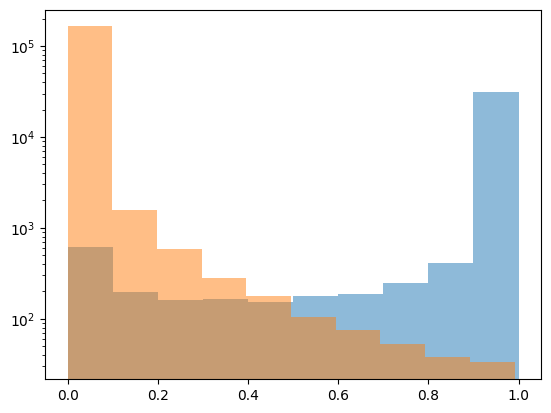

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
noise identified as noise 0.9982
signal identified as signal 0.9611


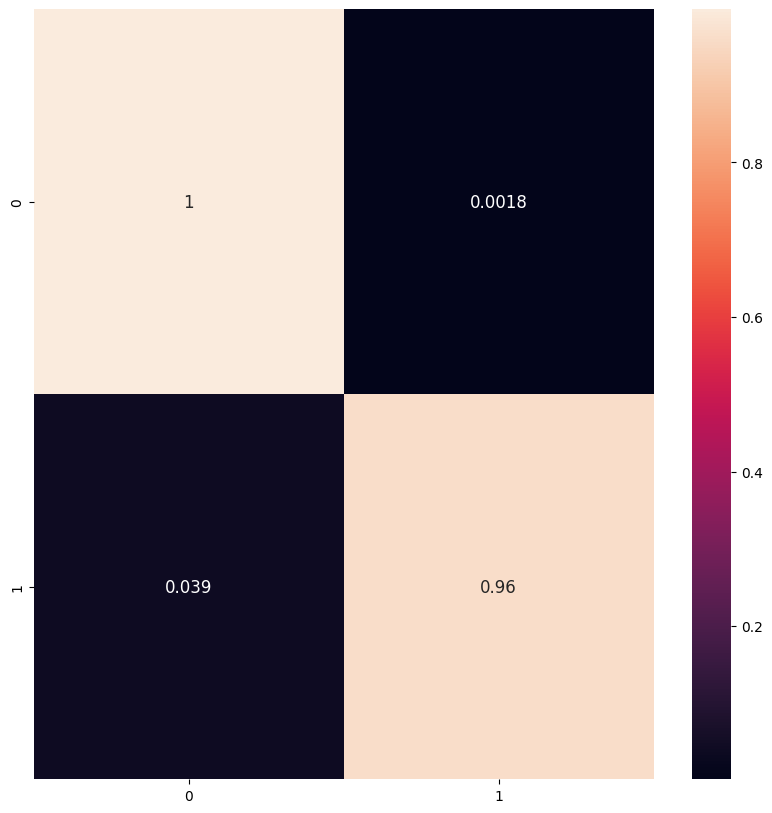

In [14]:
model2.evaluate(data_test, labels_test)

y_pred = model2.predict(data_test)
smask = labels_test == 1
plt.hist(y_pred[smask], log=True, alpha=0.5)
plt.hist(y_pred[~smask], log=True, alpha=0.5)
plt.show()
#
ypred = model2.predict(data_test)[:,0]
ypred_binary = np.zeros(len(ypred), dtype=int)
ypred_binary[ypred > 0.5] = 1

n_mask = labels_test == 0
true_n_rate = np.sum(ypred_binary[n_mask] == 0) / np.sum(n_mask)
print(f"noise identified as noise {true_n_rate:.4f}")
g_mask = labels_test == 1
true_g_rate = np.sum(ypred_binary[g_mask] == 1) / np.sum(g_mask)
print(f"signal identified as signal {true_g_rate:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(labels_test, ypred_binary, normalize='true')
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

Altering the number of filters as well as using a seperable convolution layer helps reducing the number of flops from the model from 14000 to around 4500 while maintaining good results - a first step to optimizing the model, however more tactics such as restricting the size of variables used.